#Initialize the project

In [1]:
# To generate GIFs
! pip install -q imageio
! pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 12.8MB/s 


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import PIL
from IPython import display
import glob
import imageio

#Preprocessing data

11493376/11490434 [==============================] - 0s 0us/step


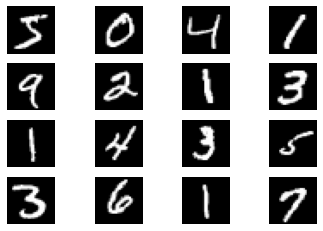

In [3]:
#Loading MNIST data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
for i in range(16):
	# define subplot
	plt.subplot(4, 4, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(train_images[i], cmap='gray')
plt.show()

In [4]:
zero_index = np.where(train_labels ==0)
zero_images = train_images[zero_index]

one_index = np.where(train_labels == 1)
one_images = train_images[one_index]

two_index = np.where(train_labels == 2)
two_images = train_images[two_index]

three_index = np.where(train_labels == 3)
three_images = train_images[three_index]

four_index = np.where(train_labels == 4)
four_images = train_images[four_index]

five_index = np.where(train_labels == 5)
five_images = train_images[five_index]

six_index = np.where(train_labels == 6)
six_images = train_images[six_index]

seven_index = np.where(train_labels == 7)
seven_images = train_images[seven_index]

eight_index = np.where(train_labels == 8)
eight_images = train_images[eight_index]

nine_index = np.where(train_labels == 9)
nine_images = train_images[nine_index]

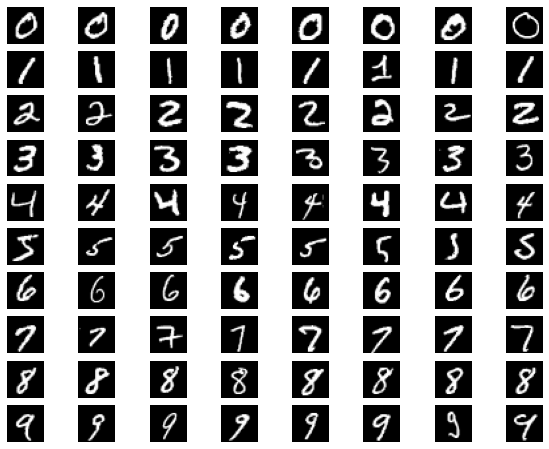

In [5]:
fig, axs = plt.subplots(10,8)
fig.set_size_inches(10,8)
temp = [zero_images,one_images,two_images,three_images,four_images,
                five_images,six_images,seven_images,eight_images,nine_images]
for dataset in range(len(temp)):
  for j in range(8):
    axs[dataset,j].imshow(temp[dataset][j], cmap='gray')
    axs[dataset,j].axis('off')
plt.show()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
train_images.shape
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
np.random.randint(0,10, 10)

array([0, 0, 0, 9, 4, 7, 5, 7, 2, 7])

In [9]:
y = np.bincount(train_labels)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

#Creating model

In [10]:
def generator_model(latent_dim=100,n_classes=10):
  # label input
  input_label = layers.Input(shape=(1,))
  embed = layers.Embedding(n_classes, 50)(input_label)
  dimension = 7 * 7
  dense = layers.Dense(dimension)(embed)
  reshape = layers.Reshape((7, 7, 1))(dense)

  # image generator input
  input_noise = layers.Input(shape=(latent_dim,))
  dimension2 = 128 * 7 * 7
  gen = layers.Dense(dimension2)(input_noise)
  gen = layers.LeakyReLU()(gen)
  gen = layers.Reshape((7, 7, 128))(gen)

  # merge image gen and label input
  merge = layers.Concatenate()([gen, reshape])
  gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False)(merge)
  gen = layers.LeakyReLU()(gen)

  gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False)(gen)
  gen = layers.LeakyReLU()(gen)

  out_layer = layers.Conv2D(1, (7, 7), padding='same', use_bias=False, activation='tanh')(gen)

  # define model
  model = tf.keras.models.Model([input_noise, input_label], out_layer)
  # model.summary()
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [11]:
def discriminator_model(input_shape= (28,28,1),classes=10):
  # input label
  input_label = layers.Input(shape=(1,))
  label_pre = layers.Embedding(classes, 50)(input_label)
  dimension = input_shape[0] * input_shape[1]
  label_pre = layers.Dense(dimension)(label_pre)
  label_pre = layers.Reshape((input_shape[0], input_shape[1], 1))(label_pre)


  # image input
  input_image = layers.Input(shape=input_shape)

  # concat label as a channel
  merge = layers.Concatenate()([input_image, label_pre])
  merge = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  merge = layers.LeakyReLU()(merge)

  merge = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  merge = layers.LeakyReLU()(merge)

  merge = layers.Flatten()(merge)
  merge = layers.Dropout(0.3)(merge)

  # output
  out_layer = layers.Dense(1, activation='sigmoid')(merge)
  # define model
  model = tf.keras.models.Model([input_image, input_label], out_layer)
  # compile model
  opt = tf.keras.optimizers.Adam(lr=0.0002)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [12]:
#Combining generative and discriminative model
def define_gan():
  discriminator.trainable = False
  gen_noise, gen_label = generator.input
  gen_output = generator.output
  gan_output = discriminator([gen_output, gen_label])
  model = tf.keras.models.Model([gen_noise, gen_label], gan_output)

  # compile model
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

#Training the model

In [13]:
def generate_fake_sample(batch_size,n_classes,noise_dim):
  image_noise = noise = tf.random.normal([batch_size, noise_dim])
  fake_labels = np.random.randint(0, n_classes, batch_size)

  images = generator([image_noise,fake_labels])
  y = tf.zeros_like(fake_labels)
  return [images, fake_labels], y

In [14]:
def generate_real_sample(batch_number, batch_size, dataset):
  images, labels = dataset

  low = batch_size*batch_number
  high = low + batch_size
  index = np.array([i for i in range(low,high)])

  batch_image = images[index]
  batch_label = labels[index]
  y = tf.ones_like(batch_label)
  return [batch_image,batch_label],y

In [15]:
def train_step(image_batch, batch_size, dataset,noise_dim,num_class):
  [real_images, real_label], y_real = generate_real_sample(image_batch, batch_size, dataset)
  [fake_images, fake_label], y_fake = generate_fake_sample(batch_size, num_class, noise_dim)

  d_loss_real, _ = discriminator.train_on_batch([real_images, real_label], y_real)
  d_loss_fake, _ = discriminator.train_on_batch([fake_images, fake_label], y_fake)

  image_noise = tf.random.normal([batch_size, noise_dim])
  fake_labels = np.random.randint(0, num_class, batch_size)
  y_gan =y = tf.ones_like(fake_labels)

  g_loss = gan_model.train_on_batch([image_noise, fake_labels], y_gan)

In [16]:
#dataset is already in batches
def train(dataset,num_batch=400,batch_size =150,epochs=100,noise_dim=100,num_class = 10):

  seed = tf.random.normal([80, noise_dim])
  label = np.array([x for x in range(10) for y in range(8)])

  for epoch in range(epochs):
    
    for image_batch in range(num_batch):
      train_step(image_batch, batch_size, dataset,noise_dim,num_class)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed, label)

    print ('Epoch {} '.format(epoch + 1))
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed, label)

In [17]:
def generate_and_save_images(model, epoch,seed, label ):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model.predict([seed,label])

  fig = plt.figure(figsize=(10, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 8, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

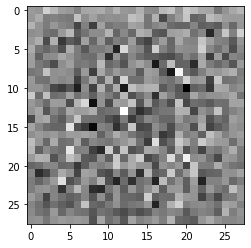

In [18]:
#Initializing the model
#Generator model
generator = generator_model()

noise = tf.random.normal([1, 100])
label = np.array([1])
generated_image = generator.predict([noise,label])

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [19]:
discriminator = discriminator_model()
decision = discriminator.predict([generated_image, np.array([1])])
print(decision)

[[0.4995358]]


In [20]:
gan_model = define_gan()

In [21]:
#Saving the training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint()

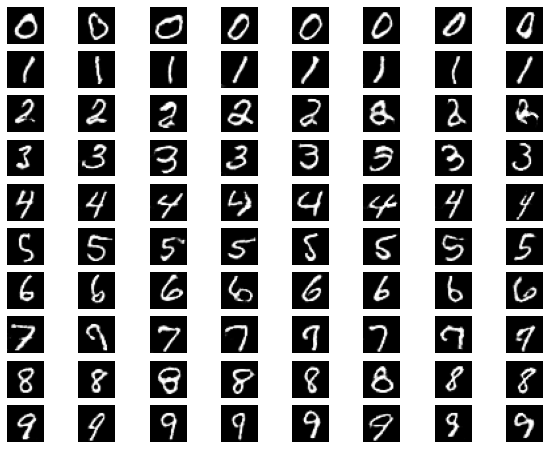

In [22]:
train((train_images, train_labels))

#Displaying results

In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

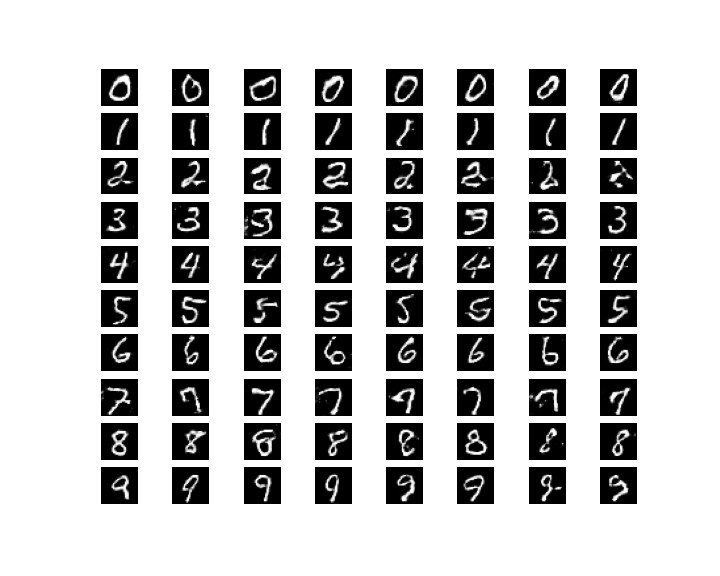

In [24]:
display_image(50)

In [25]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)